In [1]:
import sys
sys.path.append("./ml/")
import glob
import json
import struct
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import train_nnue

In [3]:
model = train_nnue.Nnue()
model.load_state_dict(torch.load("nnue.pt"))
model.adjust_leak(0)

In [4]:
data_files = glob.glob("./run-011-duck-chess/step-1*/games/*.npz")

In [5]:
make_batch = train_nnue.get_make_batch(data_files, "cpu")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:19<00:00,  2.50it/s]


Total examples: 37779226
Constant model loss: 0.8349251929902353


In [6]:
indices, offsets, which_model, lengths, targets = make_batch(1024 * 1024)

(array([16633., 16688., 16703., 16875., 37474., 37511., 38003., 37826.,
        36338., 36227., 36446., 36119., 33422., 33508., 33677., 33369.,
        28890., 28645., 28629., 28404., 28038., 28291., 28098., 28119.,
        30450., 30580., 30716., 30558., 51019., 50264., 49361., 51695.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <BarContainer object of 32 artists>)

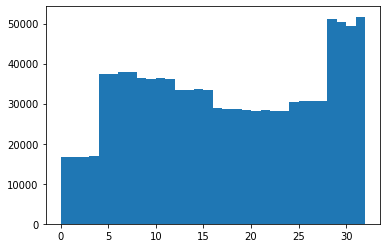

In [7]:
plt.hist(which_model.detach().numpy(), bins=range(33))

In [8]:
def estimate_loss():
    outputs = model(indices, offsets, which_model, lengths)
    return torch.mean((outputs - targets)**2)

In [9]:
estimate_loss()

tensor(0.5368, grad_fn=<MeanBackward0>)

In [10]:
# Each clipped relu wants inputs from -128 to +127 for its active range.
# If the largest intermediates we care to represent are -2.0 to +2.0,
# then this means that -2.0 should map to -32768, and +1.99... should map to +32767.
# Therefore we scale down inputs by 128 before passing them in to the clipped relu.
# Therefore, 128 * 128 = 1684 represents 1.0 as an input to relu.
# This means that a quantized weight of 128 represents the weight 1.0 in the original.
# There is one exception to this, in the original embedding layer, and all biases,
# where 16384 represents 1.0.

In [11]:
new_values = {}
quantized_weights = {}
output_right_shift = {}
for k, v in model.named_parameters():
    output_right_shift[k] = 0
    if "main_embed" in k or k == "main_bias":
        quantized = torch.round(v * 2048).to(torch.int16)
        f = quantized.float().detach() / 2048
        output_right_shift[k] = 11
    elif "bias" in k:
        quantized = torch.round(v * 16384).to(torch.int16)
        f = quantized.float().detach() / 16384
        output_right_shift[k] = 14
    else:
        quantized = torch.round(v * 128).to(torch.int8)
        f = quantized.float().detach() / 128
        output_right_shift[k] = 7
    zero_fraction = (quantized == 0).sum() / v.numel()
    new_values[k] = f
    quantized_weights[k] = quantized
    print(f"{k:20} {str(tuple(v.shape)):15} {v.min().item():.3f} {v.max().item():.3f} zero={100 * zero_fraction:.3f}%")

main_bias            (256,)          -0.368 0.025 zero=0.000%
main_embed.weight    (106496, 256)   -0.524 0.487 zero=0.618%
main_net.0.weight    (16, 256)       -0.062 0.062 zero=6.299%
main_net.0.bias      (16,)           -0.051 0.059 zero=0.000%
main_net.2.weight    (32, 16)        -0.249 0.250 zero=0.977%
main_net.2.bias      (32,)           -0.221 0.223 zero=0.000%
main_net.4.weight    (1, 32)         -0.160 0.168 zero=3.125%
main_net.4.bias      (1,)            -0.034 -0.034 zero=0.000%
networks.0.0.weight  (16, 256)       -0.365 0.264 zero=2.759%
networks.0.0.bias    (16,)           -0.060 0.088 zero=0.000%
networks.0.2.weight  (32, 16)        -0.444 0.425 zero=1.953%
networks.0.2.bias    (32,)           -0.191 0.223 zero=0.000%
networks.0.4.weight  (1, 32)         -0.245 0.307 zero=0.000%
networks.0.4.bias    (1,)            -0.151 -0.151 zero=0.000%
networks.1.0.weight  (16, 256)       -0.375 0.275 zero=3.418%
networks.1.0.bias    (16,)           -0.052 0.087 zero=0.000%
networ

In [12]:
model.load_state_dict(new_values)

<All keys matched successfully>

In [13]:
estimate_loss()

tensor(0.5368, grad_fn=<MeanBackward0>)

In [14]:
len(message_bytes) % 32

NameError: name 'message_bytes' is not defined

In [ ]:
def pack_i32(i32):
    return struct.pack("<i", i32)

In [15]:
header_alloc = 15090 #768
aligned_storage = bytearray(header_alloc)

def add_bytes(b):
    # Align to the nearest 32-byte boundary.
    padding = (32 - len(aligned_storage)) % 32
    aligned_storage.extend(b'\0' * padding)
    offset = len(aligned_storage)
    aligned_storage.extend(b)
    return offset

weights = {}
for k, v in quantized_weights.items():
    shift = output_right_shift[k]
    v = v.detach().cpu().numpy()
    k = k.replace("networks.", "n")
    k = k.replace("0.weight", "0.w")
    k = k.replace("2.weight", "1.w")
    k = k.replace("4.weight", "2.w")
    k = k.replace("0.bias", "0.b")
    k = k.replace("2.bias", "1.b")
    k = k.replace("4.bias", "2.b")
    k = k.replace("main_net.", "n0.")
    offset = add_bytes(v.tobytes())
    assert offset % 32 == 0
    weights[k] = {
        "shape": tuple(v.shape),
        "dtype": {"int8": "i8", "int16": "i16"}[str(v.dtype)],
        "offset": offset,
        "shift": shift,
    }
message = {
    "version": "v1",
    "weights": weights,
}

message_bytes = json.dumps(message).encode()
assert len(message_bytes) < header_alloc
aligned_storage[:len(message_bytes)] = message_bytes
len(message_bytes)

15084

In [16]:
with open("src/nnue-data.bin", "wb") as f:
    f.write(aligned_storage)

In [17]:
message

{'version': 'v1',
 'weights': {'main_bias': {'shape': (256,),
   'dtype': 'i16',
   'offset': 15104,
   'shift': 11},
  'main_embed.weight': {'shape': (106496, 256),
   'dtype': 'i16',
   'offset': 15616,
   'shift': 11},
  'n0.0.w': {'shape': (16, 256),
   'dtype': 'i8',
   'offset': 54546336,
   'shift': 7},
  'n0.0.b': {'shape': (16,), 'dtype': 'i16', 'offset': 54550432, 'shift': 14},
  'n0.1.w': {'shape': (32, 16), 'dtype': 'i8', 'offset': 54550464, 'shift': 7},
  'n0.1.b': {'shape': (32,), 'dtype': 'i16', 'offset': 54550976, 'shift': 14},
  'n0.2.w': {'shape': (1, 32), 'dtype': 'i8', 'offset': 54551040, 'shift': 7},
  'n0.2.b': {'shape': (1,), 'dtype': 'i16', 'offset': 54551072, 'shift': 14},
  'n1.0.w': {'shape': (16, 256),
   'dtype': 'i8',
   'offset': 54551104,
   'shift': 7},
  'n1.0.b': {'shape': (16,), 'dtype': 'i16', 'offset': 54555200, 'shift': 14},
  'n1.1.w': {'shape': (32, 16), 'dtype': 'i8', 'offset': 54555232, 'shift': 7},
  'n1.1.b': {'shape': (32,), 'dtype': 'i16',

# Debug network eval

In [ ]:
moves = [
    {"from":12,"to":28},
    {"from":16,"to":16},
    {"from":52,"to":36},
    {"from":16,"to":24},
    {"from":3,"to":39},
    {"from":24,"to":16},
    {"from":54,"to":46},
    {"from":16,"to":24},
    {"from":4,"to":12},
    {"from":24,"to":16},
    #{"from":46,"to":39},
]

In [ ]:
import engine

In [ ]:
e = engine.Engine(0)
for m in moves:
    print(e.apply_move(json.dumps(m)))
feat_indices = e.get_nnue_feature_indices()

In [ ]:
all_interm.clear()

In [ ]:
out = model(
    torch.LongTensor(feat_indices),
    torch.LongTensor([0]), # offset = 0
    torch.LongTensor([1]), # which_model = 1 (white, non-duck turn)
    torch.LongTensor([len(feat_indices)]),
)

In [ ]:
len(all_interm)

In [ ]:
for i, (k, _, _) in enumerate(all_interm): print(i, "->", k)

In [ ]:
named_params = dict(model.named_parameters())

In [ ]:
actualW = (named_params["main_net.4.weight"] * 128).to(torch.int16).numpy()

In [ ]:
actualB = (named_params["main_net.4.bias"] * (1 << 14)).to(torch.int16).numpy()

In [ ]:
actualB

In [ ]:
(all_interm[7][1][0] * (2 ** 11)).to(torch.int32)

In [ ]:
22406 - 23263

In [ ]:
all_interm[8][1][0] * (1 << 14)

In [ ]:
all_interm[6][2] * (1 << 14)

In [ ]:
actual_inp = all_interm[6][1][0] * (1 << 7)

In [ ]:
actual_inp

In [ ]:
(actual_inp.detach().numpy() @ actualW.T) + actualB

In [ ]:
((all_interm[6][1][0] * (1 << 7)).to(torch.int16) - final_out) @ actualW.T

In [ ]:
final_out = np.array([0, 0, 0, 33, 32, 0, 2, 4, 13, 27, 4, 0, 0, 0, 24, 0, 0, 0, 17, 0, 35, 0, 0, 0, 22, 0, 0, 0, 41, 0, 0, 1, ])
l2_weights = np.array([-58, -44, -25, -29, -33, 44, 10, -35, -25, -22, -37, -61, -34, 50, 31, 54, 41, 33, -25, -39, -36, 41, -30, -75, 36, 7, 44, 45, -32, 55, 7, -42, ])
#final_out = np.array([0, 0, 0, 32, 32, 0, 1, 3, 13, 27, 5, 0, 0, 0, 25, 0, 0, 0, 17, 0, 34, 0, 0, 0, 22, 0, 0, 0, 40, 0, 0, 1, ])
#l2_weights = np.array([-58, -44, -25, -29, -32, 44, 10, -35, -24, -22, -37, -60, -33, 49, 30, 53, 41, 33, -24, -39, -35, 41, -29, -74, 35, 7, 43, 45, -31, 55, 7, -41, ])

In [ ]:
final_out @ l2_weights + actualB

In [ ]:
(all_interm[6][1][0] * (1 << 7)).to(torch.int16)

In [ ]:
all_interm[6][2] * (1 << 14)

In [ ]:
all_interm[7]

In [ ]:
0.2458 * 2**14

In [ ]:
0.0057 * (1<<14)

In [ ]:
W, B = list(all_interm[6][0].parameters())
print(W)
print(B)

In [ ]:
inp = (all_interm[6][1][0] * (1 << 7)).to(torch.int16)

In [ ]:
all_interm[6][1][0] * (1 << 7)

In [ ]:
(W * (1<<7)).to(torch.int16)

In [ ]:
inp

In [ ]:
discW = (W * (1<<7))
discW

In [ ]:
discW @ inp.T

In [ ]:
discW * inp

In [ ]:
layer1_out @ l2_weights

In [ ]:
(layer1_out - inp.numpy()) @ discW.numpy().T

In [ ]:
l2_weights - discW.numpy()

In [ ]:
B * (1 << 14)

In [ ]:
W @ all_interm[6][1][0].T + B

In [ ]:
(W @ all_interm[6][1][0].T) * (1 << 14)

In [ ]:
B * (1 << 14)

In [ ]:
-0.2458 * (1 << 14)

In [ ]:
final_out @ l2_weights + 658

In [ ]:
named_params["main_net.4.bias"] * (1 << 14)

In [ ]:
# final linear: 6
# tanh: 8
all_interm[6][2] * (1 << 14)

In [ ]:
all

In [ ]:
all_interm[8][1][0] * (1 << 14)

In [ ]:
# This is the value of the accumulator after the bias.
actual_bias_accum = (all_interm[1][1][0] * (1 << 14)).to(torch.int16).flatten().detach().cpu().numpy()

In [ ]:
actual_bias_accum >> 7

In [ ]:
named_params["main_net.0.bias"] * (1<<14)

In [ ]:
named_params.keys()

In [ ]:
actual_bias_accum

In [ ]:
named_params["main_net.0.weight"] @ torch.tensor(actual_bias_accum, dtype=torch.float32)

In [ ]:
actual_bias_accum

In [ ]:
net15_layer0_relu_out = all_interm[-7][2]

In [ ]:
all_interm[-8]

In [ ]:
all_interm[-7]

In [ ]:
(net15_layer0_relu_out * 128)

In [ ]:
[-37, 58, -128, -128, -111, 127, -128, 127, 7, 127, 86, -71, 4, 18, 59, -33, ]

In [ ]:
# This is the value after the output of the first 

In [ ]:
got_bias_accum = [-519, -2097, 562, -935, -997, -865, -987, 173, -129, -171, 1882, -374, -2370, -2726, -1761, 1660, -1485, -864, 35, 1272, -1144, -236, 111, -721, 1092, -682, 78, -629, 534, -1210, 460, 2297, 1448, 430, 380, 653, 2503, 3478, 2327, -802, -1461, -1176, 2011, -57, -2465, 951, -2316, 282, -1075, -1156, 764, -2629, 1007, 1007, -1518, 282, -958, -979, 1722, -1216, 70, 967, -1257, 257, -1530, 1152, -781, -1637, 2012, 350, 394, 591, -1985, -1174, -571, -1077, 688, 426, -2330, 1147, 2871, 195, 734, -1578, 2591, -913, 854, 99, 791, 946, -169, 502, 341, 853, -605, 905, 1086, 197, 1830, 1066, -1152, 581, -379, -1033, 2337, 2633, -907, -1041, 2413, -1487, 97, -583, -665, 2397, -789, 1610, -247, -1253, 1132, 1023, 2142, 577, 2226, 474, 1253, -822, 464, 937, -308, 1133, 1918, 1586, -61, 1667, 152, 2451, -2310, -350, -263, 2936, -931, -1699, 226, 2023, 2052, 3179, 708, -1076, -56, 18, -770, -616, 1128, 795, 661, 1224, 698, -500, 303, -2285, 399, 726, -1000, -495, -1726, 9, 3, 2023, 1206, 1785, -1451, -150, 1919, -454, -206, 866, -1221, 1666, 3826, 96, 754, -949, -1907, 1779, 115, 1250, -2197, -1081, 2082, -249, 393, 153, 505, 1045, 1317, 1034, -530, 617, -1590, -797, 830, -956, 152, 1824, -2101, -185, -2641, -977, -771, -1098, -4271, 935, -793, -1011, -1523, -81, -139, 24, 834, 86, -1014, -154, -275, 2687, -45, 1453, 411, 2, -1469, 49, -515, -1821, -1520, -3629, -847, -614, 402, 2753, -1172, -791, 648, -2406, 516, -294, 103, 529, 2048, -2499, 1080, 746, 1662, 1833, -1099, -360, -1200, -63, ]

In [ ]:
actual

In [ ]:
plt.plot(actual)
plt.plot(got)

In [ ]:
out